In [4]:
import pandas as pd
import numpy as np
data = pd.read_csv(r'BlackFriday.csv')

                   

In [5]:
data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [36]:
pers = data.drop_duplicates(subset = 'User_ID', keep = 'first')
pers = pers.reset_index()
pers = pers.drop(columns = ['index','Product_ID','Product_Category_1','Product_Category_2','Product_Category_3','Purchase'])
pers['Occupation'].dtype
ynowork = pers['Occupation'].tolist()
ynowork2 = pers['Gender'].tolist()
pers.head()

,User_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status
0,1000001,F,0-17,10,A,2,0
1,1000002,M,55+,16,C,4+,0
2,1000003,M,26-35,15,A,3,0
3,1000004,M,46-50,7,B,2,1
4,1000005,M,26-35,20,A,1,1


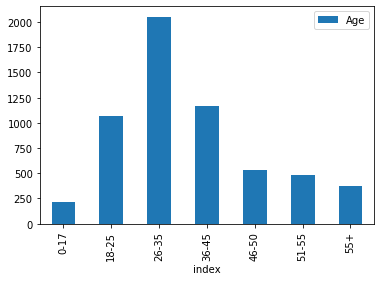

In [43]:
AgeData = pers.Age.value_counts().to_frame()
#AgeData = AgeData.to_frame()
AgeData['NewInd'] = [2, 3, 1, 4, 5, 6, 0]
AgeData = AgeData.sort_values(by=['NewInd'],ascending = True)
AgeData = AgeData.reset_index()
AgeData.plot.bar(x = 'index', y = 'Age')

#AgeData

In [51]:
Feature_table = pd.DataFrame(index = np.unique(data.User_ID))
grouped = data.groupby('User_ID')
Feature_table['Sum_Purchases'] = grouped.Purchase.sum()
Feature_table['Count_Purchases'] = grouped.Purchase.count()
Feature_table['Catagories'] = grouped.Product_Category_1.nunique()
Feature_table = Feature_table.reset_index()
featsHold = Feature_table

#grouped.head()
Feature_table.head()

,index,Sum_Purchases,Count_Purchases,Catagories
0,1000001,333481,34,10
1,1000002,810353,76,5
2,1000003,341635,29,6
3,1000004,205987,13,1
4,1000005,821001,106,12


In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from time import time

In [11]:
MinMax = MinMaxScaler()
MinMax.fit(Feature_table)
Feature_transformed = MinMax.transform(Feature_table)

In [12]:
data1 = pd.DataFrame(Feature_transformed)
data1.columns = ['TotalSpent', 'NumPurchase', 'NumCats']
data1 = data1.set_index(featsHold['index'])
data1['Occupation'] = ynowork
data1.head()

,TotalSpent,NumPurchase,NumCats,Occupation
index,,,,
1000001,0.027579,0.028431,0.529412,10
1000002,0.073027,0.069608,0.235294,16
1000003,0.028356,0.023529,0.294118,15
1000004,0.015428,0.007843,0.000000,7
1000005,0.074041,0.099020,0.647059,20


In [13]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data1, test_size= 0.1, random_state= 42, shuffle= True)
lTr = train['Occupation']
lTe = test['Occupation']
FeaTr = train.drop(columns = ['Occupation'])
FeaTe = test.drop(columns = ['Occupation'])

In [14]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

clf = SVC(C = 5, kernel = 'poly')
clf.fit(FeaTr,lTr)
pred = clf.predict(FeaTe)

print(accuracy_score(lTe,pred))

C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.13050847457627118


# New Feature Table Generation

In [174]:
trxData = data[['User_ID', 'Product_Category_1']]
groups = trxData.groupby(['User_ID', 'Product_Category_1']).agg(Count=('Product_Category_1', 'count'))
type(groups)
groups.head()#.get_group((1000001,8))

Count
User_ID Product_Category_1       
1000001 1                       4
        2                       1
        3                      11
        4                       2
        5                       2

In [175]:
iterables = [trxData.User_ID.unique().tolist(),range(1,19)]
index = pd.MultiIndex.from_product(iterables, names = ['User_ID','Product_Category_1'])
NewFrame = pd.DataFrame(index = index)


In [184]:
NewFrame1 = ( groups
             .reset_index()
             .pivot(index = 'User_ID',columns = 'Product_Category_1')
             .fillna(0)
            )
#NewFeatures = NewFrame1
NewFrame1['Gender'] = ynowork2

NewFrame1.Gender = NewFrame1.Gender.replace(to_replace = ['M', 'F'],value = [0, 1])

NewFrame1.head(50)
#plt.pie(NewFeatures.Gender.value_counts())

Count                                                      \
Product_Category_1      1     2     3     4      5     6    7     8    9   10   
User_ID                                                                         
1000001               4.0   1.0  11.0   2.0    2.0   1.0  0.0   8.0  0.0  0.0   
1000002              31.0   1.0   0.0   0.0   13.0   6.0  0.0  25.0  0.0  0.0   
1000003              15.0   2.0   1.0   0.0    9.0   0.0  0.0   1.0  0.0  0.0   
1000004              13.0   0.0   0.0   0.0    0.0   0.0  0.0   0.0  0.0  0.0   
1000005              18.0   2.0   1.0   3.0   20.0   6.0  5.0  44.0  0.0  0.0   
1000006               8.0   3.0   5.0   5.0   12.0   1.0  0.0   6.0  0.0  0.0   
1000007              14.0   0.0   0.0   0.0    1.0   0.0  0.0   0.0  0.0  0.0   
1000008              22.0   1.0   1.0   0.0    7.0   3.0  0.0  42.0  0.0  0.0   
1000009              11.0   0.0   5.0   0.0    9.0   7.0  1.0  21.0  0.0  0.0   
1000010              46.0  19.0  16.0   7.0   80.0   2.0  1.0  40.0  0.0  0.0   
1000011               7.0   3.0   1.0   1.0   35.0   3.0  2.0  14.0  0.0  0.0   
1000012               3.0   1.0   0.0   0.0    4.0   1.0  0.0   1.0  0.0  1.0   
1000013              33.0  20.0   0.0   0.0    1.0   2.0  0.0   3.0  0.0  0.0   
1000014               4.0   0.0   0.0   0.0    3.0   1.0  0.0   4.0  0.0  0.0   
1000015              31.0   3.0   1.0   1.0   31.0   9.0  0.0  29.0  0.0  0.0   
1000016               6.0   2.0   0.0   0.0   10.0   0.0  0.0   2.0  0.0  0.0   
1000017              37.0   7.0   3.0   1.0   13.0   8.0  0.0  19.0  1.0  3.0   
1000018              81.0  16.0  20.0  12.0   17.0   9.0  0.0  22.0  0.0  1.0   
1000019              55.0   3.0  18.0   1.0   24.0   1.0  0.0  13.0  1.0  0.0   
1000020              10.0   0.0   0.0   0.0    1.0   0.0  0.0   0.0  0.0  0.0   
1000021               4.0   2.0   5.0   0.0    1.0   1.0  0.0   0.0  0.0  0.0   
1000022              56.0   9.0   2.0   0.0   65.0   3.0  0.0  10.0  0.0  1.0   
1000023              53.0  14.0   5.0   4.0   37.0  17.0  2.0  13.0  0.0  3.0   
1000024              19.0   3.0   1.0   0.0   35.0   1.0  0.0  16.0  0.0  0.0   
1000025              28.0   2.0   3.0   0.0    6.0   0.0  0.0   3.0  0.0  0.0   
1000026              42.0   9.0   7.0   7.0  101.0   3.0  0.0  45.0  0.0  0.0   
1000027               4.0   4.0   2.0   0.0   15.0   3.0  0.0   8.0  0.0  4.0   
1000028               9.0   0.0   2.0   1.0   17.0   4.0  0.0  17.0  0.0  1.0   
1000029              46.0   1.0   0.0   0.0    0.0   0.0  0.0   1.0  0.0  1.0   
1000030               3.0   1.0   1.0   1.0    8.0   3.0  2.0  10.0  0.0  0.0   
1000031               9.0   1.0   2.0   2.0   46.0   1.0  0.0   1.0  0.0  0.0   
1000032               2.0   0.0   2.0   1.0    3.0   3.0  0.0   8.0  0.0  0.0   
1000033              46.0   6.0   2.0   7.0   36.0  10.0  1.0  58.0  0.0  2.0   
1000034              10.0   4.0   5.0   4.0   58.0   1.0  0.0  10.0  0.0  0.0   
1000035              11.0   0.0   6.0   2.0   42.0   2.0  0.0  37.0  0.0  1.0   
1000036              68.0   1.0   6.0   2.0   69.0   7.0  6.0  26.0  0.0  2.0   
1000037               5.0   0.0   2.0   1.0   13.0   1.0  0.0   5.0  0.0  0.0   
1000039               9.0   3.0   1.0   1.0   12.0   3.0  0.0   8.0  0.0  0.0   
1000041               4.0   0.0   0.0   1.0    3.0   0.0  0.0   2.0  0.0  0.0   
1000042              74.0   8.0   1.0   4.0   21.0   0.0  0.0   8.0  0.0  1.0   
1000043               2.0   0.0   2.0   0.0    5.0   0.0  0.0   3.0  0.0  0.0   
1000044              36.0  14.0   8.0   8.0   23.0   1.0  0.0  18.0  0.0  0.0   
1000045               6.0   5.0   4.0   7.0  108.0   0.0  0.0  26.0  0.0  0.0   
1000046               3.0   0.0   0.0   0.0    2.0   0.0  0.0   1.0  0.0  0.0   
1000047               2.0   0.0   0.0   0.0    1.0   2.0  0.0   9.0  0.0  0.0   
1000048             109.0  25.0  17.0  19.0   89.0   6.0  1.0  46.0  0.0  1.0   
1000049              30.0   2.0  14.0   0.0    1.0 

In [185]:
train, test = train_test_split(NewFeatures, test_size= 0.2, shuffle= True)
lTr = train['Gender']
lTe = test['Gender']
FeaTr = train.drop(columns = ['Gender'])
FeaTe = test.drop(columns = ['Gender'])

t0 = time()
clf = SVC(C = 100, kernel = 'rbf',gamma = 0.0001, random_state = 42)
clf.fit(FeaTr,lTr)
print ("training time:", round(time()-t0, 3), "s")

t0 = time()
pred = clf.predict(FeaTe)

print(accuracy_score(lTe,pred))

training time: 3.324 s
0.7201017811704835
